In [26]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter, OrderedDict

plt.rcParams["figure.figsize"] = (8,6)

In [27]:
# загружаем датасет
df = pd.read_pickle("df.pkl")
df_unique = pd.read_pickle("df_unique.pkl")

<AxesSubplot:xlabel='views', ylabel='Count'>

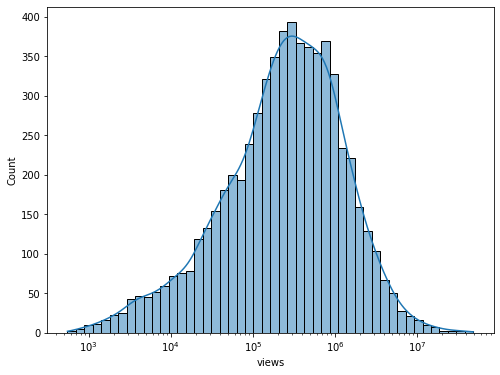

In [28]:
# на скольки видео есть различное количество просмотров
sns.histplot(data=df_unique, x="views", log_scale=True, kde=True)

<AxesSubplot:xlabel='likes', ylabel='Count'>

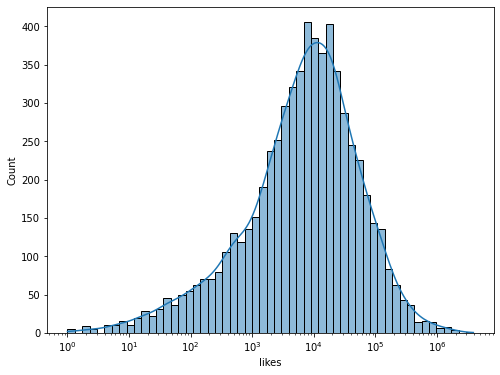

In [29]:
# на скольки видео есть различное количество лайков
sns.histplot(data=df_unique[df_unique["likes"] > 0], x="likes", log_scale=True, kde=True)

<AxesSubplot:xlabel='dislikes', ylabel='Count'>

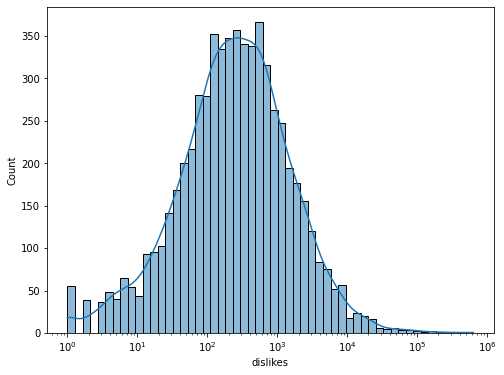

In [30]:
# на скольки видео есть различное количество дизлайков
sns.histplot(data=df_unique[df_unique["dislikes"] > 0], x="dislikes", log_scale=True, kde=True)

<AxesSubplot:xlabel='comment_count', ylabel='Count'>

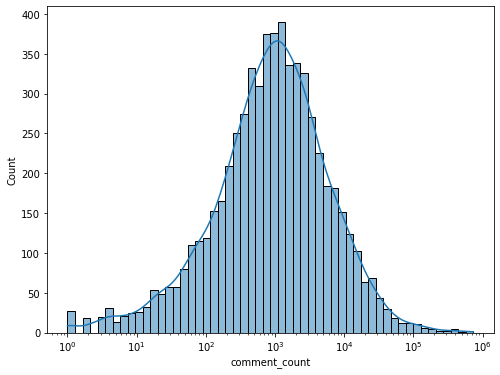

In [31]:
# на скольки видео есть различное количество комментариев
sns.histplot(data=df_unique[df_unique["comment_count"] > 0], x="comment_count", log_scale=True, kde=True)

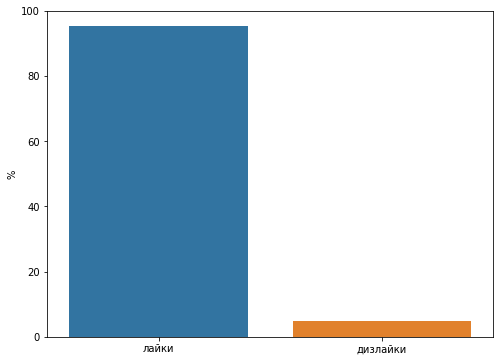

In [32]:
# соотношение лайков и дизлайков
likes_count = np.sum(df["likes"])
dislikes_count = np.sum(df["dislikes"])
likes_percent = float(likes_count) / (likes_count + dislikes_count) * 100
dislikes_percent = float(dislikes_count) / (likes_count + dislikes_count) * 100
sns.barplot(y=[likes_percent, dislikes_percent], x=["лайки", "дизлайки"])
plt.ylabel("%")
plt.show()

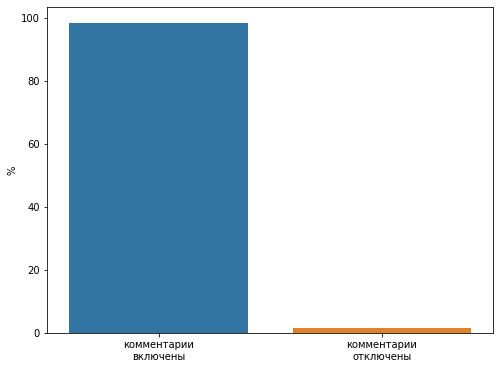

In [33]:
# на каком % видео отключены комментарии
dis_percent = float(df[df["comments_disabled"] == True].shape[0]) / df.shape[0] * 100
sns.barplot(y=[100 - dis_percent, dis_percent], x=["комментарии\nвключены", "комментарии\nотключены"])
plt.ylabel("%")
plt.show()

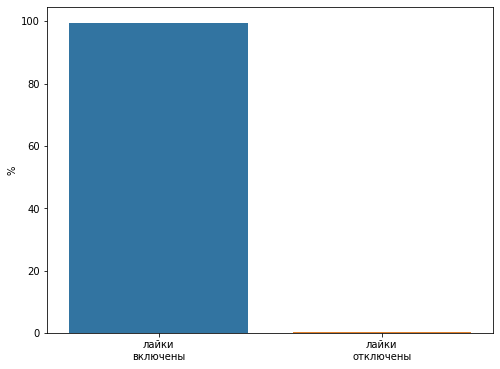

In [34]:
# на каком % видео отключены лайки
dis_percent = float(df[df["ratings_disabled"] == True].shape[0]) / df.shape[0] * 100
sns.barplot(y=[100 - dis_percent, dis_percent], x=["лайки\nвключены", "лайки\nотключены"])
plt.ylabel("%")
plt.show()

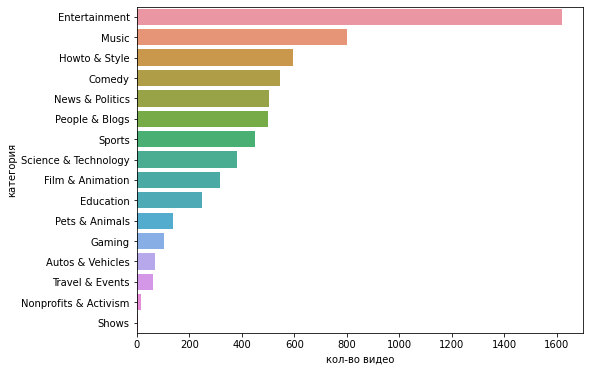

In [35]:
# топ популярных категорий
tmp = Counter(df_unique["category"])
top_categories = OrderedDict(sorted(tmp.items(), key=lambda t: t[1], reverse=True))

sns.barplot(y=list(top_categories.keys()), x=list(top_categories.values()))
plt.xlabel('кол-во видео')
plt.ylabel('категория')
plt.show()

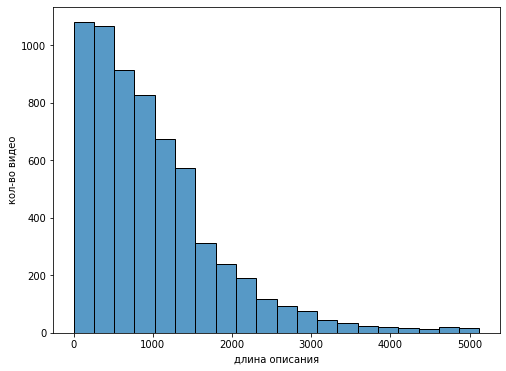

In [36]:
# распределение длин описания (в символах)
sns.histplot([len(str(s)) for s in df_unique["description"]], bins=20)
plt.xlabel('длина описания')
plt.ylabel('кол-во видео')
plt.show()

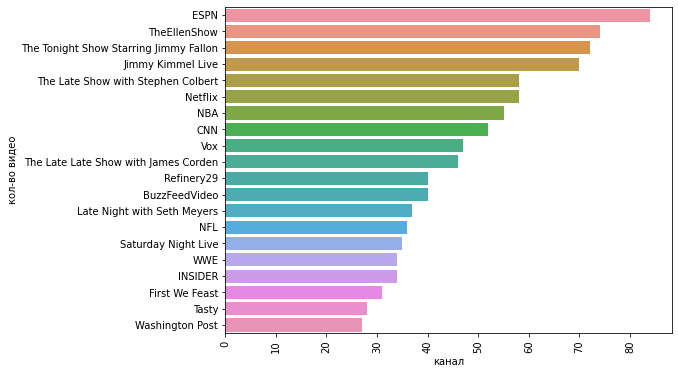

In [37]:
# топ каналов, чаще всего попадавших в тренды
tmp = Counter(df_unique["channel_title"])
top_channels = OrderedDict(sorted(tmp.items(), key=lambda t: t[1], reverse=True)[:20])
sns.barplot(y=list(top_channels.keys()), x=list(top_channels.values()))
plt.xticks(rotation=90)
plt.xlabel('канал')
plt.ylabel('кол-во видео')
plt.show()

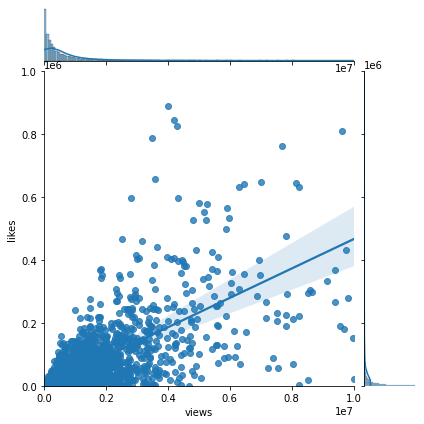

In [38]:
# отношение количества лайков к количеству просмотров
sns.jointplot(data=df_unique[df_unique["likes"] > 0], x="views", y="likes", kind="reg", xlim=(0, 10_000_000), ylim=(0, 1_000_000))

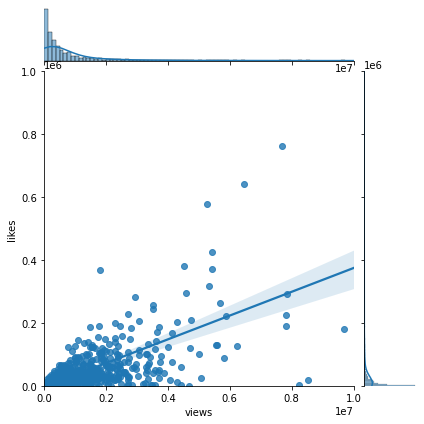

In [39]:
# отношение количества лайков к количеству просмотров для видео категории Entertainment (id = 24)
sns.jointplot(data=df_unique[(df_unique["category"] == "Entertainment") & (df_unique["likes"] > 0)], x="views", y="likes", kind="reg", xlim=(0, 10_000_000), ylim=(0, 1_000_000))

22 days 12:29:35.342465
4215 days 00:00:00


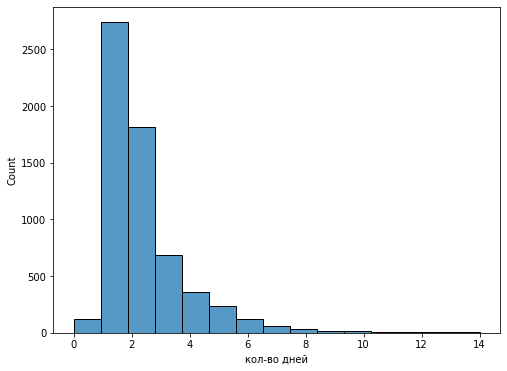

In [40]:
# гипотеза 1: видео попадают в тренды в среднем за 3 дня
days_to_trends = df.drop_duplicates(subset="video_id", keep="first")[["trending_date", "publish_time"]]
days_to_trends["publish_time"] = days_to_trends["publish_time"].dt.floor(freq="D")
delta = days_to_trends["trending_date"] - days_to_trends["publish_time"]
print(np.mean(delta))
print(np.max(delta))
sns.histplot([d.days for d in delta if d.days < 15], bins=15)
plt.xlabel("кол-во дней")
plt.show()
# гипотеза опровергнута - среднее значение составляет 22.5 дня
# некоторые видео попадают в тренды спустя более 10 лет после добавления на youtube

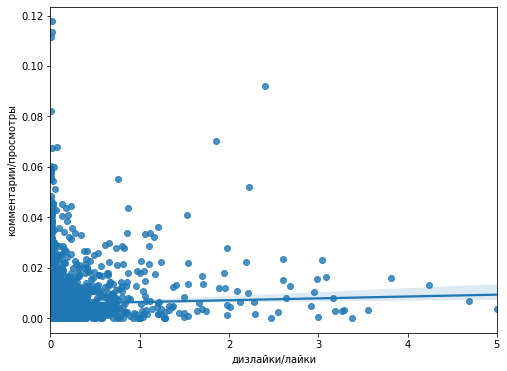

In [41]:
# гипотеза 2:
# при большем отношении дизлайков к лайкам выше отношение комментариев к просмотрам (когда зрителю не нравится видео он пойдет писать гневный комментарий)
dislikes_to_likes = [row["dislikes"] / row["likes"] for _, row in df_unique[df_unique["likes"] > 0].iterrows()]
comments_to_views = [row["comment_count"] / row["views"] for _, row in df_unique[df_unique["likes"] > 0].iterrows()]
sns.regplot(x=dislikes_to_likes, y=comments_to_views)
plt.xlim((0, 5))
plt.xlabel("дизлайки/лайки")
plt.ylabel("комментарии/просмотры")
plt.show()
# гипотеза подтверждена - по линии тренда видим небольшую прямую зависимость

<AxesSubplot:>

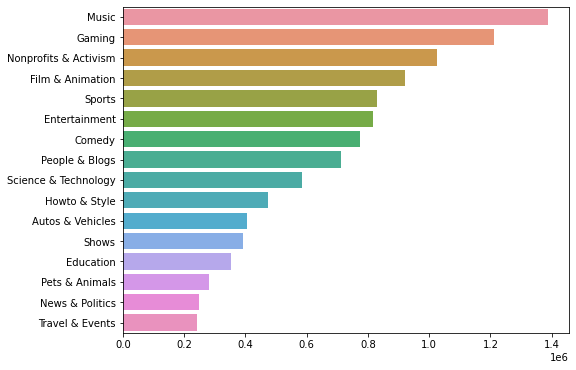

In [42]:
# гипотеза 3:
# из типов видео больше всего просмотров в среднем набирают клипы
views_by_categories = {str(key): int(val) for key, val in df_unique.groupby("category")[["views"]].mean().sort_values("views", ascending=False).iterrows()}
sns.barplot(y=list(views_by_categories.keys()), x=list(views_by_categories.values()))
# гипотеза подтверждена

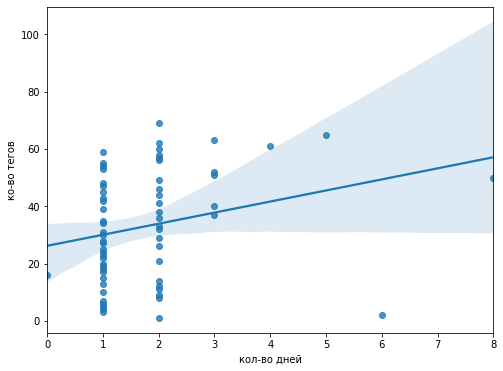

In [43]:
# гипотеза 4: видео с бОльшим количеством тегов быстрее попадает в тренды
tags = [t.iloc[0] for _, t in df.drop_duplicates(subset="video_id", keep="first")[["tags"]].iterrows()]
tags_to_days = {len(t): d for t, d in zip(tags, [d.days for d in delta]) if d < 15}
sns.regplot(y=list(tags_to_days.keys()), x=list(tags_to_days.values()))
plt.xlabel("кол-во дней")
plt.ylabel("ко-во тегов")
plt.show()
# гипотеза отпровергнута - при большем количестве тегов попадание в тренды дольше

<AxesSubplot:>

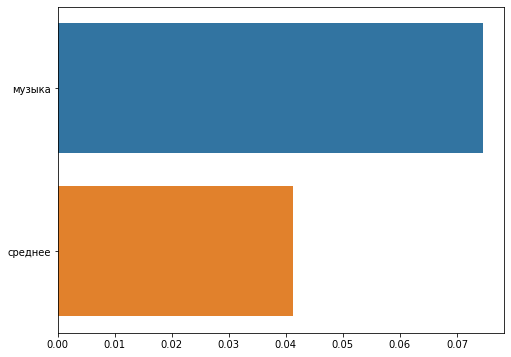

In [44]:
# гипотеза 5: на клипах меньше отношение лайков к просмотрам, чем у других видео в среднем (так как их просмотры сильно раздуты от пересматривания)
views_by_categories = {str(key): int(val) for key, val in df_unique.groupby("category")[["views"]].sum().iterrows()}
likes_by_categories = {str(key): int(val) for key, val in df_unique.groupby("category")[["likes"]].sum().iterrows()}
views_to_likes = {key: likes_by_categories[key] / views_by_categories[key] for key in views_by_categories.keys()}

sns.barplot(y=["музыка", "среднее"], x=[views_to_likes["Music"], np.mean(list(views_to_likes.values()))])
# гипотеза опровергнута